## Comparison of PPO, SAC, and TD3

>Note: run all `ppo.ipynb`, `sac.ipynb`, and `td3.ipynb` which will save the necessry data in `temp/` folder before running this notebook.

## Load the data

In [6]:
from rejax import PPO, SAC, TD3
import numpy as np
from pathlib import Path

algos = [PPO, SAC, TD3]

training_curve_by_algo = {}
rendered_frames_by_algo = {}
returns_by_algo = {}

for algo in algos:
    algo_name = algo.__name__
    training_curve_path = Path(f"temp/{algo_name}_training_curve.npy")
    rendered_frames_path = Path(f"temp/{algo_name}_rendered_frames.npy")
    returns_path = Path(f"temp/{algo_name}_returns.npy")

    if any(not path.exists() for path in [training_curve_path, rendered_frames_path, returns_path]):
        print(f"‼️ Skipping {algo_name} because the data files do not exist, run the corresponding notebook first.")
        continue

    training_curve_by_algo[algo_name] = np.load(training_curve_path)
    rendered_frames_by_algo[algo_name] = np.load(rendered_frames_path, allow_pickle=True)
    returns_by_algo[algo_name] = np.load(returns_path)

## Plot training curves

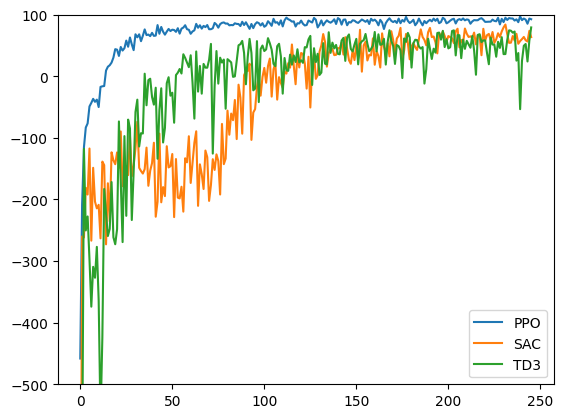

In [49]:
from matplotlib import pyplot as plt

for algo_name, training_curve in training_curve_by_algo.items():
    plt.plot(training_curve, label=algo_name)
    # limit y axis to go from -400
    plt.ylim(-500, 100)
plt.legend()
plt.savefig("temp/training_curves_merged.png")
plt.show()

## Evaluation on the test rooms

The following table shows the reward in each test room for each algorithm. In the last row we show the average reward and the standard deviation across all test rooms.

In [8]:
import pandas as pd

# Create the DataFrame with episodes as rows and algorithms as columns
df = pd.DataFrame(returns_by_algo)

# Add Average and Std as new rows
df.loc["Average"] = df.mean()
df.loc["Std"] = df.std()

# Set episode labels safely
episode_labels = [f"Episode {i + 1}" for i in range(len(df) - 2)] + ["Average", "Std"]
df.index = pd.Index(episode_labels)

df = df.round(2)
df

,PPO,SAC,TD3
Episode 1,99.599998,99.500000,99.730003
Episode 2,99.580002,99.449997,99.769997
Episode 3,98.370003,96.510002,99.320000
Episode 4,97.559998,86.269997,38.459999
Episode 5,98.540001,-61.430000,99.220001
Episode 6,99.750000,99.540001,99.709999
Episode 7,66.760002,-27.520000,-26.950001
Episode 8,98.269997,98.730003,99.480003
Episode 9,99.660004,99.650002,99.750000
Episode 10,99.070000,98.279999,99.070000


In [9]:
num_episodes = min(len(frames) for frames in rendered_frames_by_algo.values())
num_episodes

10

## Visualization of the learned policies on the test rooms

In [32]:
from typing import List
from env_vis import Frame
from IPython.display import Image as IPImage


def pad_episode(episode_frames: List[Frame], length: int) -> List[Frame]:
    return (
        episode_frames + [episode_frames[-1]] * (length - len(episode_frames))
        if len(episode_frames) < length
        else episode_frames[:length]
    )


num_episodes = min(len(frames) for frames in rendered_frames_by_algo.values())

# lengths of episodes are different for each algorithm, so we pad the shorter ones with the last frame
# so that the episodes in gifs are properly aligned and can be easily compared
for episode_idx in range(num_episodes):
    max_episode_length = max(len(frames[episode_idx]) for frames in rendered_frames_by_algo.values())

    # also truncate episodes longer than 100 frames
    max_episode_length = min(max_episode_length, 100)

    for algo_name, frames in rendered_frames_by_algo.items():
        frames[episode_idx] = pad_episode(frames[episode_idx], max_episode_length)

In [42]:
{algo_name: len(frames) for algo_name, frames in rendered_frames_by_algo.items()}

{'PPO': 10, 'SAC': 10, 'TD3': 10}

In [41]:
from env_vis import save_gif

# flatten all frames for all algorithms
flattened_frames_by_algo = {
    algo_name: [frame for frames in rendered_frames_by_algo[algo_name] for frame in frames]
    for algo_name in rendered_frames_by_algo
}

# Merge frames from all algorithms into one
merged_frames = np.concatenate([flattened_frames_by_algo[algo_name] for algo_name in flattened_frames_by_algo], axis=2)

save_gif(merged_frames, Path("temp/merged_frames.gif"))

GIF saved to temp/merged_frames.gif


In [ ]:
display(IPImage(filename="temp/merged_frames.gif"))